# Exploring the differences between medicinal and non medicinal plants using chemical classes

### Import modules

In [1]:
from collections import defaultdict
from ast import literal_eval

import pandas as pd
from tqdm import tqdm

# Import taxonomy
from utils import get_genus_and_family_info_for_plants

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl

In [2]:
sns.set_style("whitegrid")
mpl.rcParams['figure.dpi'] = 360
%matplotlib inline

In [3]:
tqdm.pandas()

In [4]:
pd.set_option('display.max_columns', None)

Load plant-chemical and plant-disease associations

In [5]:
plant_disease_df = pd.read_csv(
    's3://enveda-datascience/daniel_domingo/plant_disease_associations.tsv.gz',
    compression='gzip',
    sep='\t',
)

In [6]:
plant_disease_df.head(1)

,plant_curie,plant_name,disease_curie,database,evidence
0,ncbitaxon:3369,Cryptomeria japonica,mondo:0005324,bern2,10067319_8


Medicinal plants

In [7]:
medicinal_plants = plant_disease_df.plant_curie.unique()

Load chemicals

In [8]:
plant_chemical_df = pd.read_csv(
    's3://enveda-datascience/daniel_domingo/plant_chemical_associations.tsv.zip',
    compression='zip',
    sep='\t',
    usecols=[
        'plant_curie',
        'chemical_curie',
    ]
)

In [9]:
plant_chemical_df.head(1)

,plant_curie,chemical_curie
0,ncbitaxon:1000425,pubchem.compound:3527


In [10]:
len(plant_chemical_df.chemical_curie.unique())

71179

### Annontate medicinal and non-medicinal plants

In [11]:
plant_chemical_df['plant_type'] = plant_chemical_df['plant_curie'].progress_map(
    lambda x: 'Medicinal' if x in medicinal_plants else 'Non-medicinal'
)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 330655/330655 [00:57<00:00, 5757.68it/s]


In [12]:
plant_chemical_df.head(2)

,plant_curie,chemical_curie,plant_type
0,ncbitaxon:1000425,pubchem.compound:3527,Non-medicinal
1,ncbitaxon:1000425,pubchem.compound:68082,Non-medicinal


### Extract chemical classes

Load ClassyFire classes

In [13]:
classyfire_dict = pd.read_csv(
    's3://enveda-datascience/daniel_domingo/classyfire_smiles.tsv.gz',
    sep='\t',
    compression='gzip',
    usecols=[
        'smiles',
        'class.name'
    ],
    index_col='smiles'
).to_dict()['class.name']

In [14]:
len(classyfire_dict)

64321

Load NPClassifier classes

In [15]:
np_classifier_dict = pd.read_csv(
    's3://enveda-datascience/daniel_domingo/npclassifier_smiles.tsv.gz',
    sep='\t',
    compression='gzip',
    usecols=[
        'pubchem_openeye_can_smiles',
        'superclass_results'
    ],
    index_col='pubchem_openeye_can_smiles'
).to_dict()['superclass_results']

In [16]:
len(np_classifier_dict)

638605

Convert the SMILEs to PubChem ids

In [17]:
smiles_df = pd.read_csv(
    's3://enveda-datascience/daniel_domingo/smiles.tsv.gz',
    sep='\t',
    compression='gzip',
)

In [18]:
pubchem_to_smiles = {}
all_smiles = set()

chemicals_in_plants = set(plant_chemical_df.chemical_curie.unique())

for pubchem_id, smiles in tqdm(smiles_df.values):
        
    if pubchem_id.startswith('pubchem:'):
        pubchem_id = pubchem_id.replace('pubchem:', 'pubchem.compound:')
        
    if pubchem_id not in chemicals_in_plants:
        continue
    
    all_smiles.add(smiles)
    pubchem_to_smiles[pubchem_id] = smiles

smiles_to_pubchem = {
    smiles: pubchem
    for pubchem, smiles in pubchem_to_smiles.items()
}

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 323369/323369 [00:00<00:00, 402607.42it/s]


In [19]:
classyfire_dict = {
    smiles_to_pubchem[smile]: classes
    for smile, classes in classyfire_dict.items()
    if smile in smiles_to_pubchem
}
len(classyfire_dict)

1644

In [20]:
# Multiple classes associated with each chemical
np_classifier_dict = {
    smiles_to_pubchem[smile]: literal_eval(classes)
    for smile, classes in np_classifier_dict.items()
    if smile in smiles_to_pubchem and len(literal_eval(classes)) > 0
}
len(np_classifier_dict)

38828

### Compound class annotation

In [21]:
classyfire_annotated_plants = plant_chemical_df.copy(deep=True)
classyfire_annotated_plants['class'] = classyfire_annotated_plants['chemical_curie'].map(classyfire_dict)

In [22]:
# all plants
classyfire_annotated_plants.shape

(330655, 4)

In [23]:
classyfire_annotated_plants.dropna(subset=['class'], inplace=True)

In [24]:
classyfire_annotated_plants.shape

(11605, 4)

In [25]:
classyfire_annotated_plants['plant_type'].value_counts()

Medicinal        7169
Non-medicinal    4436
Name: plant_type, dtype: int64

In [26]:
classyfire_annotated_plants['class'].value_counts()

Prenol lipids                               2909
Fatty Acyls                                 2649
Saturated hydrocarbons                      1564
Organooxygen compounds                      1499
Benzene and substituted derivatives          615
                                            ... 
Oxolanes                                       1
Organic phosphoric acids and derivatives       1
Organobromides                                 1
Organic sulfonic acids and derivatives         1
Organic sulfuric acids and derivatives         1
Name: class, Length: 82, dtype: int64

In [27]:
np_classifier_annotated_plants = plant_chemical_df.copy(deep=True)
np_classifier_annotated_plants['class'] = np_classifier_annotated_plants['chemical_curie'].map(np_classifier_dict)
np_classifier_annotated_plants = np_classifier_annotated_plants.explode('class')

In [28]:
# all plants
np_classifier_annotated_plants.shape

(338277, 4)

In [29]:
np_classifier_annotated_plants.dropna(subset=['class'], inplace=True)

In [30]:
np_classifier_annotated_plants.shape

(236180, 4)

In [31]:
np_classifier_annotated_plants['plant_type'].value_counts()

Non-medicinal    123497
Medicinal        112683
Name: plant_type, dtype: int64

In [32]:
np_classifier_annotated_plants['class'].value_counts()

Flavonoids                             43498
Triterpenoids                          21286
Sesquiterpenoids                       19274
Monoterpenoids                         16777
Diterpenoids                           14188
                                       ...  
Diazotetronic acids and derivatives        7
Mycosporine derivatives                    2
Fluorenes                                  2
Docosanoids                                1
Tropolones                                 1
Name: class, Length: 71, dtype: int64

### Create plant-class vectors
e.g., plant A: [class1, class2, class3, ...]

In [66]:
def create_np_classifier_vectors(df: pd.DataFrame):
    all_classes = set(df['class'].unique())
    plants = set(df['plant_curie'].unique())
    
    vector_data = []
    
    for plant_name in tqdm(plants, desc='Generated NP-Classifier vectors'):
        phytochem_df = df[df['plant_curie'] == plant_name]
        total_chem = len(phytochem_df['chemical_curie'].unique())
        
        t = {
            'plant_name': plant_name,
        }
        
        for class_name in all_classes:
            temp = phytochem_df[phytochem_df['class'] == class_name]
            t[class_name] = len(temp['chemical_curie'].unique())
        
        vector_data.append(t)
            
    return pd.DataFrame(vector_data)
    

def create_classyfire_vectors(df: pd.DataFrame):
    all_classes = set(df['class'].unique())
    plants = set(df['plant_curie'].unique())
    
    vector_data = []
    
    for plant_name in tqdm(plants, desc='Generated Classifier vectors'):
        phytochem_df = df[df['plant_curie'] == plant_name]
        total_chem = len(phytochem_df['chemical_curie'].unique())
        
        t = {
            'plant_name': plant_name,
        }
        
        for class_name in all_classes:
            temp = phytochem_df[phytochem_df['class'] == class_name]
            t[class_name] = len(temp['chemical_curie'].unique())
        
        vector_data.append(t)
            
    return pd.DataFrame(vector_data)

In [ ]:
plant_to_npclassifier_vectors = create_np_classifier_vectors(np_classifier_annotated_plants)

Generated NP-Classifier vectors:  10%|█████████▌                                                                                       | 1559/15911 [01:02<09:31, 25.11it/s]

In [ ]:
plant_to_npclassifier_vectors.head(2)

In [ ]:
plant_to_classyfire_vectors = create_classyfire_vectors(classyfire_annotated_plants)

In [ ]:
plant_to_classyfire_vectors.head(2)

### Collapsing plant species to plant families

In [38]:
_, family_to_species = get_genus_and_family_info_for_plants(
    set(plant_chemical_df.plant_curie.unique())
)

order genus: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16857/16857 [00:00<00:00, 25750.97it/s]


In [39]:
def get_familiy_stats():
    
    family_data = []
    
    for family_name in tqdm(family_to_species):
        tmp = plant_chemical_df[plant_chemical_df['plant_curie'].isin(family_to_species[family_name])]
        val_counts = tmp['plant_type'].value_counts().to_dict()
        
        for plant_type, plant_count in val_counts.items():
            family_data.append({
                'family': family_name,
                'plant_count': plant_count,
                'plant_type': plant_type
            })
        
    df = pd.DataFrame(family_data)
    df.set_index('family', inplace=True)
    df.fillna(0, inplace=True)
    
    g = sns.displot(
        data=df,
        x='plant_count',
        hue='plant_type',
        stat="percent",
        kde=True,
        common_norm=False,
        height=4,
        aspect=1.5,
        bins=1000,
        alpha=0.7,
        palette={
            'Medicinal': '#f4b183',
            'Non-medicinal': '#2dea99',
        },
    )

    g.set(xlim=(-1, 1000))

    plt.show()

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 504/504 [00:07<00:00, 71.73it/s]


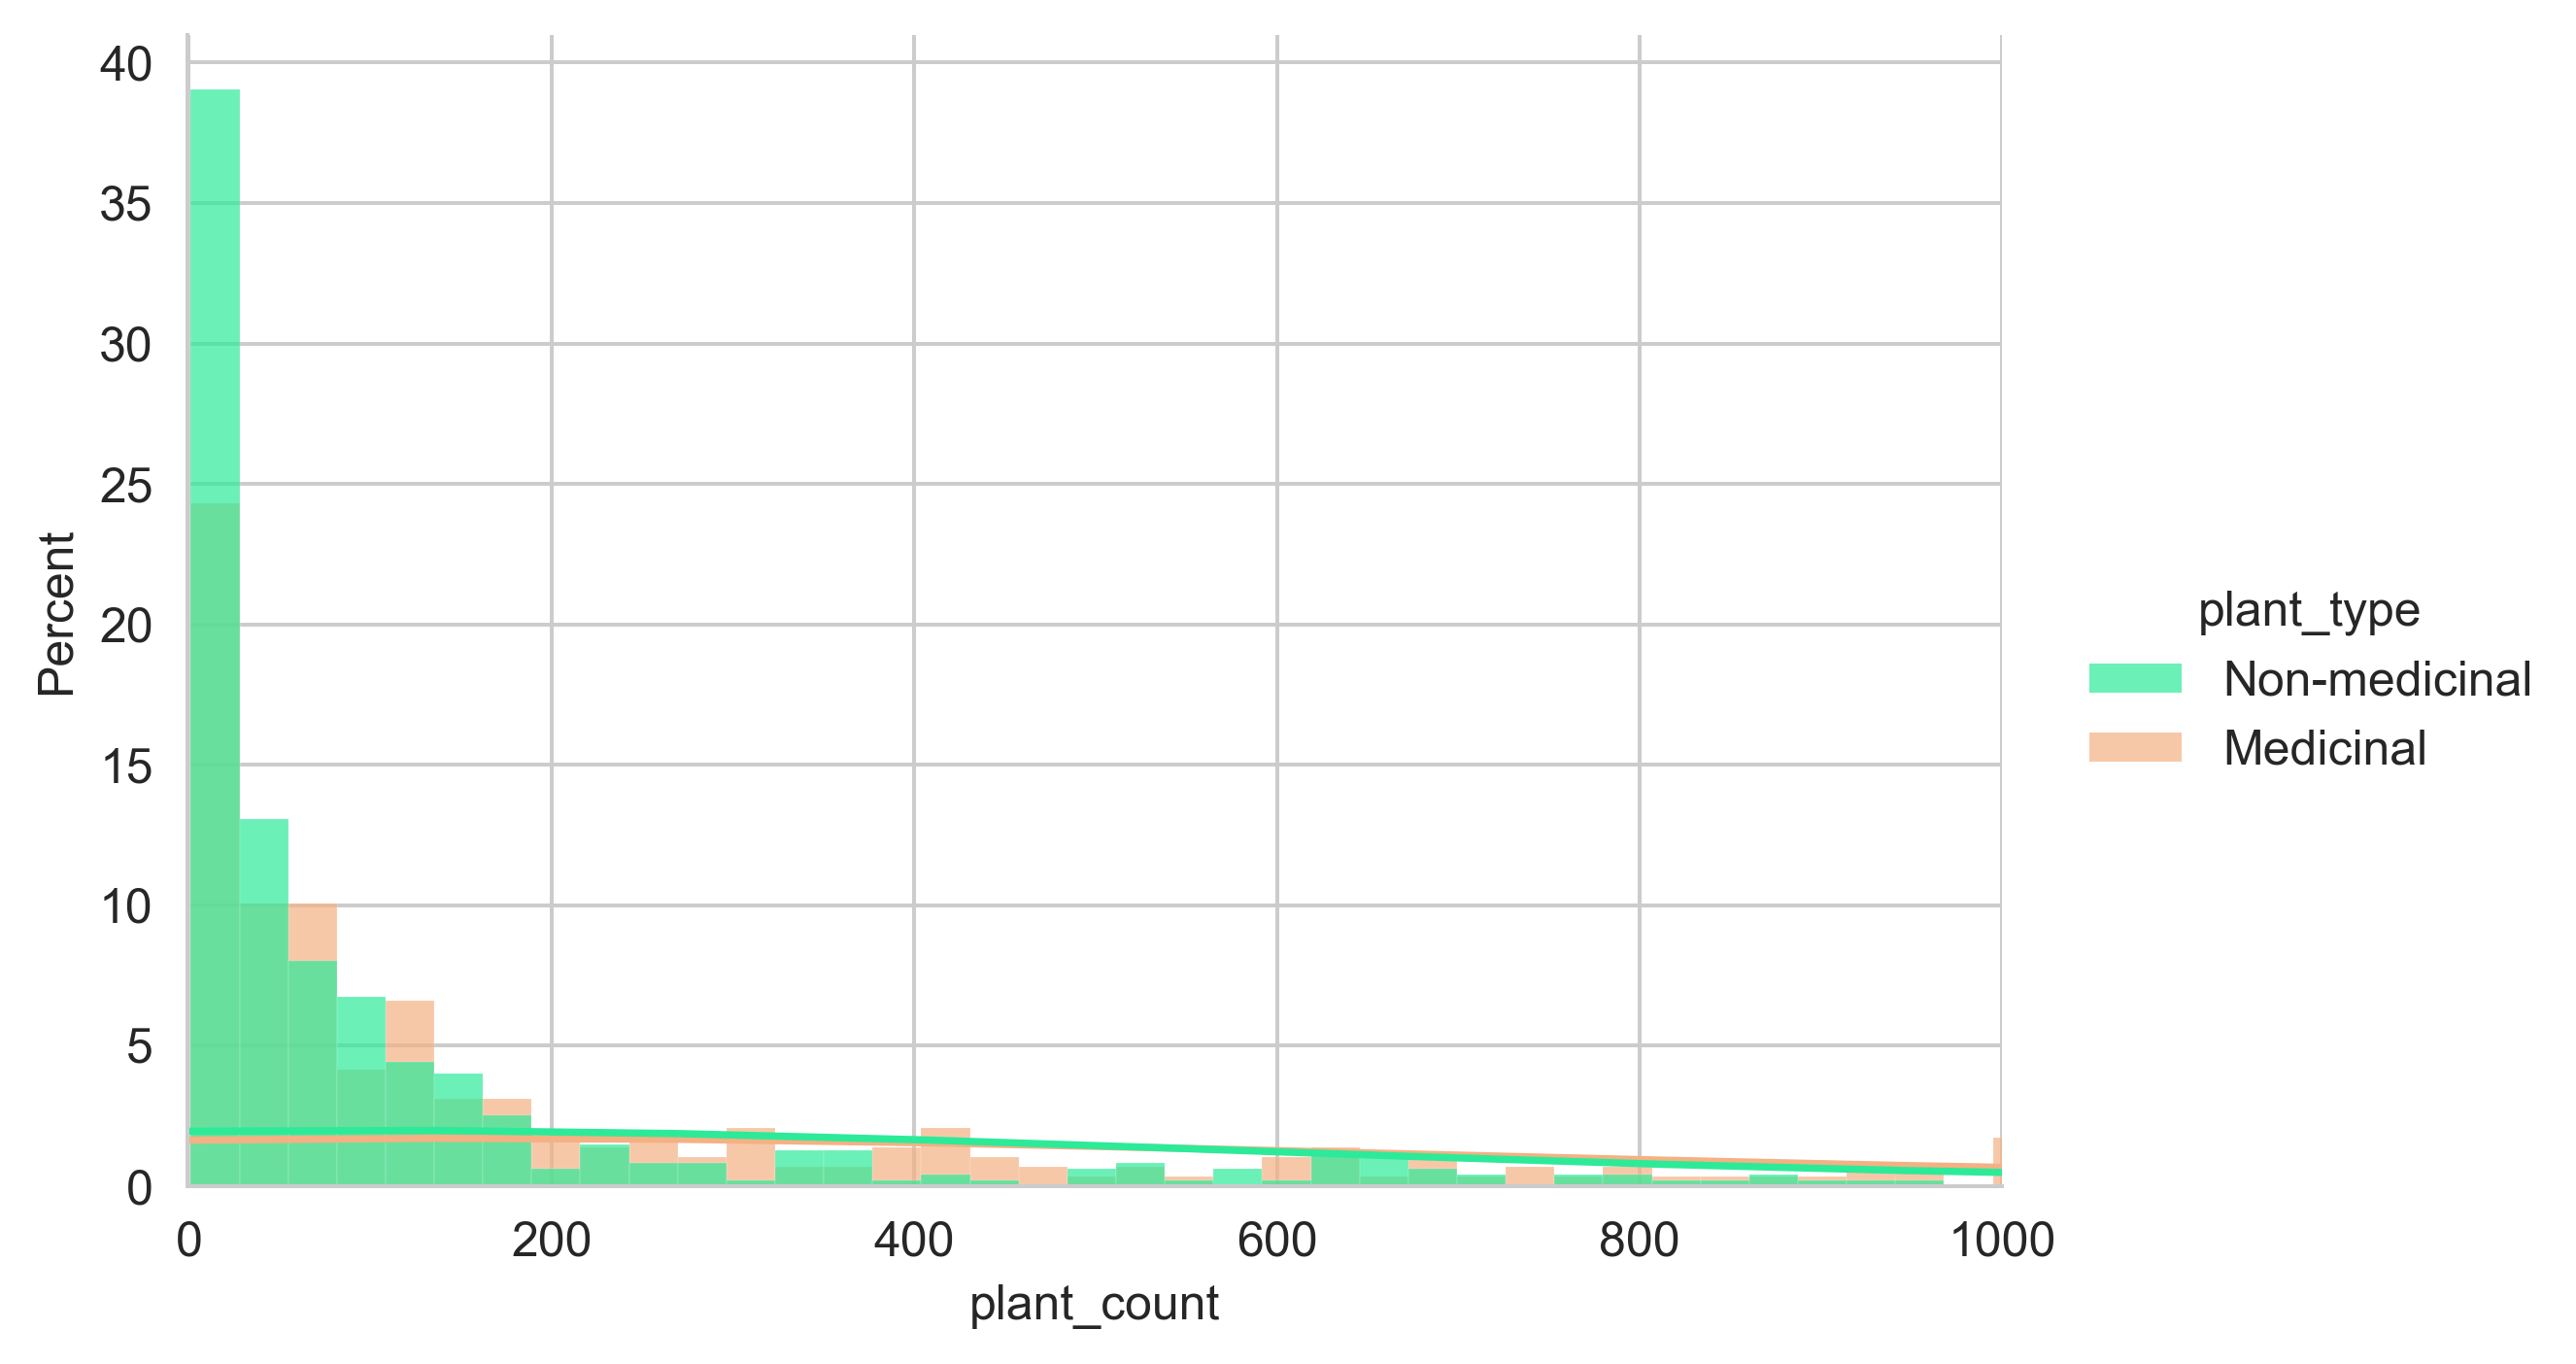

In [40]:
get_familiy_stats()

In [ ]:
def collapse_to_family(df: pd.DataFrame):
    
    data = []
    
    # Medicinal flag mapping
    k = plant_chemical_df[['plant_curie', 'plant_type']]
    k.set_index('plant_curie', inplace=True)
    mapper = k.to_dict()['plant_type']
    df['plant_type'] = df['plant_name'].map(mapper)
    
    for family_name in tqdm(family_to_species):
        tmp_df = df[df['plant_name'].isin(family_to_species[family_name])]
        tmp_df = tmp_df.drop(columns=['plant_name'])
        
        med_dict = tmp_df[tmp_df['plant_type'] == 'Medinical'].mean(numeric_only=True).to_dict()
        med_dict['family'] = family_name
        med_dict['ftype'] = 'Medicinal'
        data.append(med_dict)
        
        non_med_dict = tmp_df[tmp_df['plant_type'] == 'Non-medicinal'].mean(numeric_only=True).to_dict()
        non_med_dict['family'] = family_name
        non_med_dict['ftype'] = 'Non-medicinal'
        data.append(non_med_dict)
    
    return pd.DataFrame(data)
        

In [ ]:
classyfire_family_df = collapse_to_family(plant_to_classyfire_vectors)
classyfire_family_df.fillna(0, inplace=True)
classyfire_family_df.head(2)

In [ ]:
np_classifier_family_df = collapse_to_family(plant_to_npclassifier_vectors)
np_classifier_family_df.fillna(0, inplace=True)
np_classifier_family_df.head(2)

### Converting to percentage

### PCA plot

In [44]:
from sklearn.decomposition import PCA

In [52]:
pca_classyfire = PCA(n_components=3, random_state=42)
X = classyfire_family_df.drop(columns=['family', 'ftype'])
classyfire_components = pca_classyfire.fit_transform(X)

principal_classyfire_df = pd.DataFrame(
    data = classyfire_components, 
    columns = ['PC1', 'PC2', 'PC3']
)
principal_classyfire_df['Type'] = classyfire_family_df['ftype']

In [62]:
X.describe()

,Benzopyrans,Organic phosphines and derivatives,Cinnamaldehydes,Hydroxy acids and derivatives,Phenols,Coumarins and derivatives,Sulfoxides,Tetrathianes,Heteroaromatic compounds,Piperidines,Thiophenes,Furans,Glycerolipids,Oxazinanes,Organic sulfuric acids and derivatives,Dithiins,Organic trisulfides,Organic disulfides,Thioacetals,Benzothiazoles,Dioxanes,Cinnamic acids and derivatives,Dihydrofurans,Azepanes,Thiols,Isocoumarins and derivatives,Diazanaphthalenes,Pyrrolidines,Phenol ethers,Indoles and derivatives,Dithianes,Tropones,Quinolines and derivatives,Organic phosphoric acids and derivatives,Unsaturated hydrocarbons,Naphthalenes,"3,4-dihydrocoumarins",Tetrahydrofurans,Organic sulfonic acids and derivatives,Oxolanes,Trithianes,Isothiocyanates,Benzoxazines,Lactones,Macrolactams,Pyrrolizidines,Imidazopyrimidines,Dithiolanes,Pyrrolines,Thioethers,Tetralins,Epoxides,Pyridines and derivatives,Fatty Acyls,Carboxylic acids and derivatives,Prenol lipids,Oxanes,Organooxygen compounds,Sulfinyl compounds,Tropane alkaloids,Phenalenes,Benzopyrazoles,Benzene and substituted derivatives,Saturated hydrocarbons,Polycyclic hydrocarbons,Organic dithiophosphoric acids and derivatives,Thiosulfinic acid esters,Organometalloid compounds,Organoiodides,Pyrroles,Tetrahydroisoquinolines,Organobromides,Benzimidazoles,Allyl sulfur compounds,Sulfenyl compounds,Azolidines,Sulfonyls,Azoles,Pyrans,Diazines,Keto acids and derivatives,Organonitrogen compounds
count,1008.0,1008.000000,1008.000000,1008.0,1008.000000,1008.000000,1008.000000,1008.0,1008.000000,1008.000000,1008.000000,1008.0,1008.000000,1008.0,1008.0,1008.000000,1008.000000,1008.000000,1008.000000,1008.000000,1008.0,1008.000000,1008.000000,1008.0,1008.0,1008.000000,1008.000000,1008.000000,1008.000000,1008.000000,1008.000000,1008.000000,1008.000000,1008.0,1008.000000,1008.000000,1008.000000,1008.0,1008.0,1008.0,1008.000000,1008.000000,1008.0,1008.000000,1008.0,1008.000000,1008.000000,1008.000000,1008.000000,1008.0,1008.0,1008.000000,1008.000000,1008.000000,1008.000000,1008.000000,1008.000000,1008.000000,1008.0,1008.000000,1008.000000,1008.000000,1008.000000,1008.000000,1008.00000,1008.0,1008.000000,1008.0,1008.0,1008.0,1008.0,1008.0,1008.000000,1008.000000,1008.000000,1008.000000,1008.000000,1008.000000,1008.000000,1008.000000,1008.000000,1008.000000
mean,0.0,0.003779,0.003307,0.0,0.083041,0.000096,0.137672,0.0,0.112307,0.298661,0.000719,0.0,0.329545,0.0,0.0,0.001438,0.033706,0.015327,0.003779,0.007086,0.0,0.034778,0.000575,0.0,0.0,0.001006,0.026647,0.103199,0.012337,0.044194,0.001002,0.000144,0.013689,0.0,0.308122,0.039328,0.011023,0.0,0.0,0.0,0.060617,0.141511,0.0,0.442866,0.0,0.028142,0.296346,0.049603,0.000230,0.0,0.0,0.000288,0.406882,4.558319,0.041140,7.272179,0.017682,1.501204,0.0,0.111204,0.049603,0.004960,0.943744,2.775609,0.00002,0.0,0.020633,0.0,0.0,0.0,0.0,0.0,0.049603,0.031907,0.021278,0.006614,0.118882,0.265539,0.028364,0.003165,0.014172,0.837377
std,0.0,0.119989,0.104990,0.0,1.764114,0.003043,2.040586,0.0,3.157169,3.806912,0.022824,0.0,3.900196,0.0,0.0,0.045648,0.755538,0.303206,0.119989,0.224979,0.0,0.575343,0.018259,0.0,0.0,0.031954,0.663838,1.368905,0.351942,0.743467,0.031815,0.004565,0.395792,0.0,3.704128,0.680948,0.349967,0.0,0.0,0.0,1.581409,2.784341,0.0,4.081098,0.0,0.652148,4.287259,1.574852,0.007291,0.0,0.0,0.009130,4.493420,15.844718,0.398899,21.985777,0.408562,8.860592,0.0,2.524175,1.574852,0.157485,6.275685,12.252266,0.00063,0.0,0.496653,0.0,0.0,0.0,0.0,0.0,1.574852,0.630161,0.630849,0.209980,3.169958,3.868826,0.508492,0.062326,0.449958,7.147532
min,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0

In [53]:
pca_classyfire.explained_variance_ratio_

array([0.40041166, 0.20407849, 0.11925447])

AttributeError: PathCollection.set() got an unexpected keyword argument 'z'

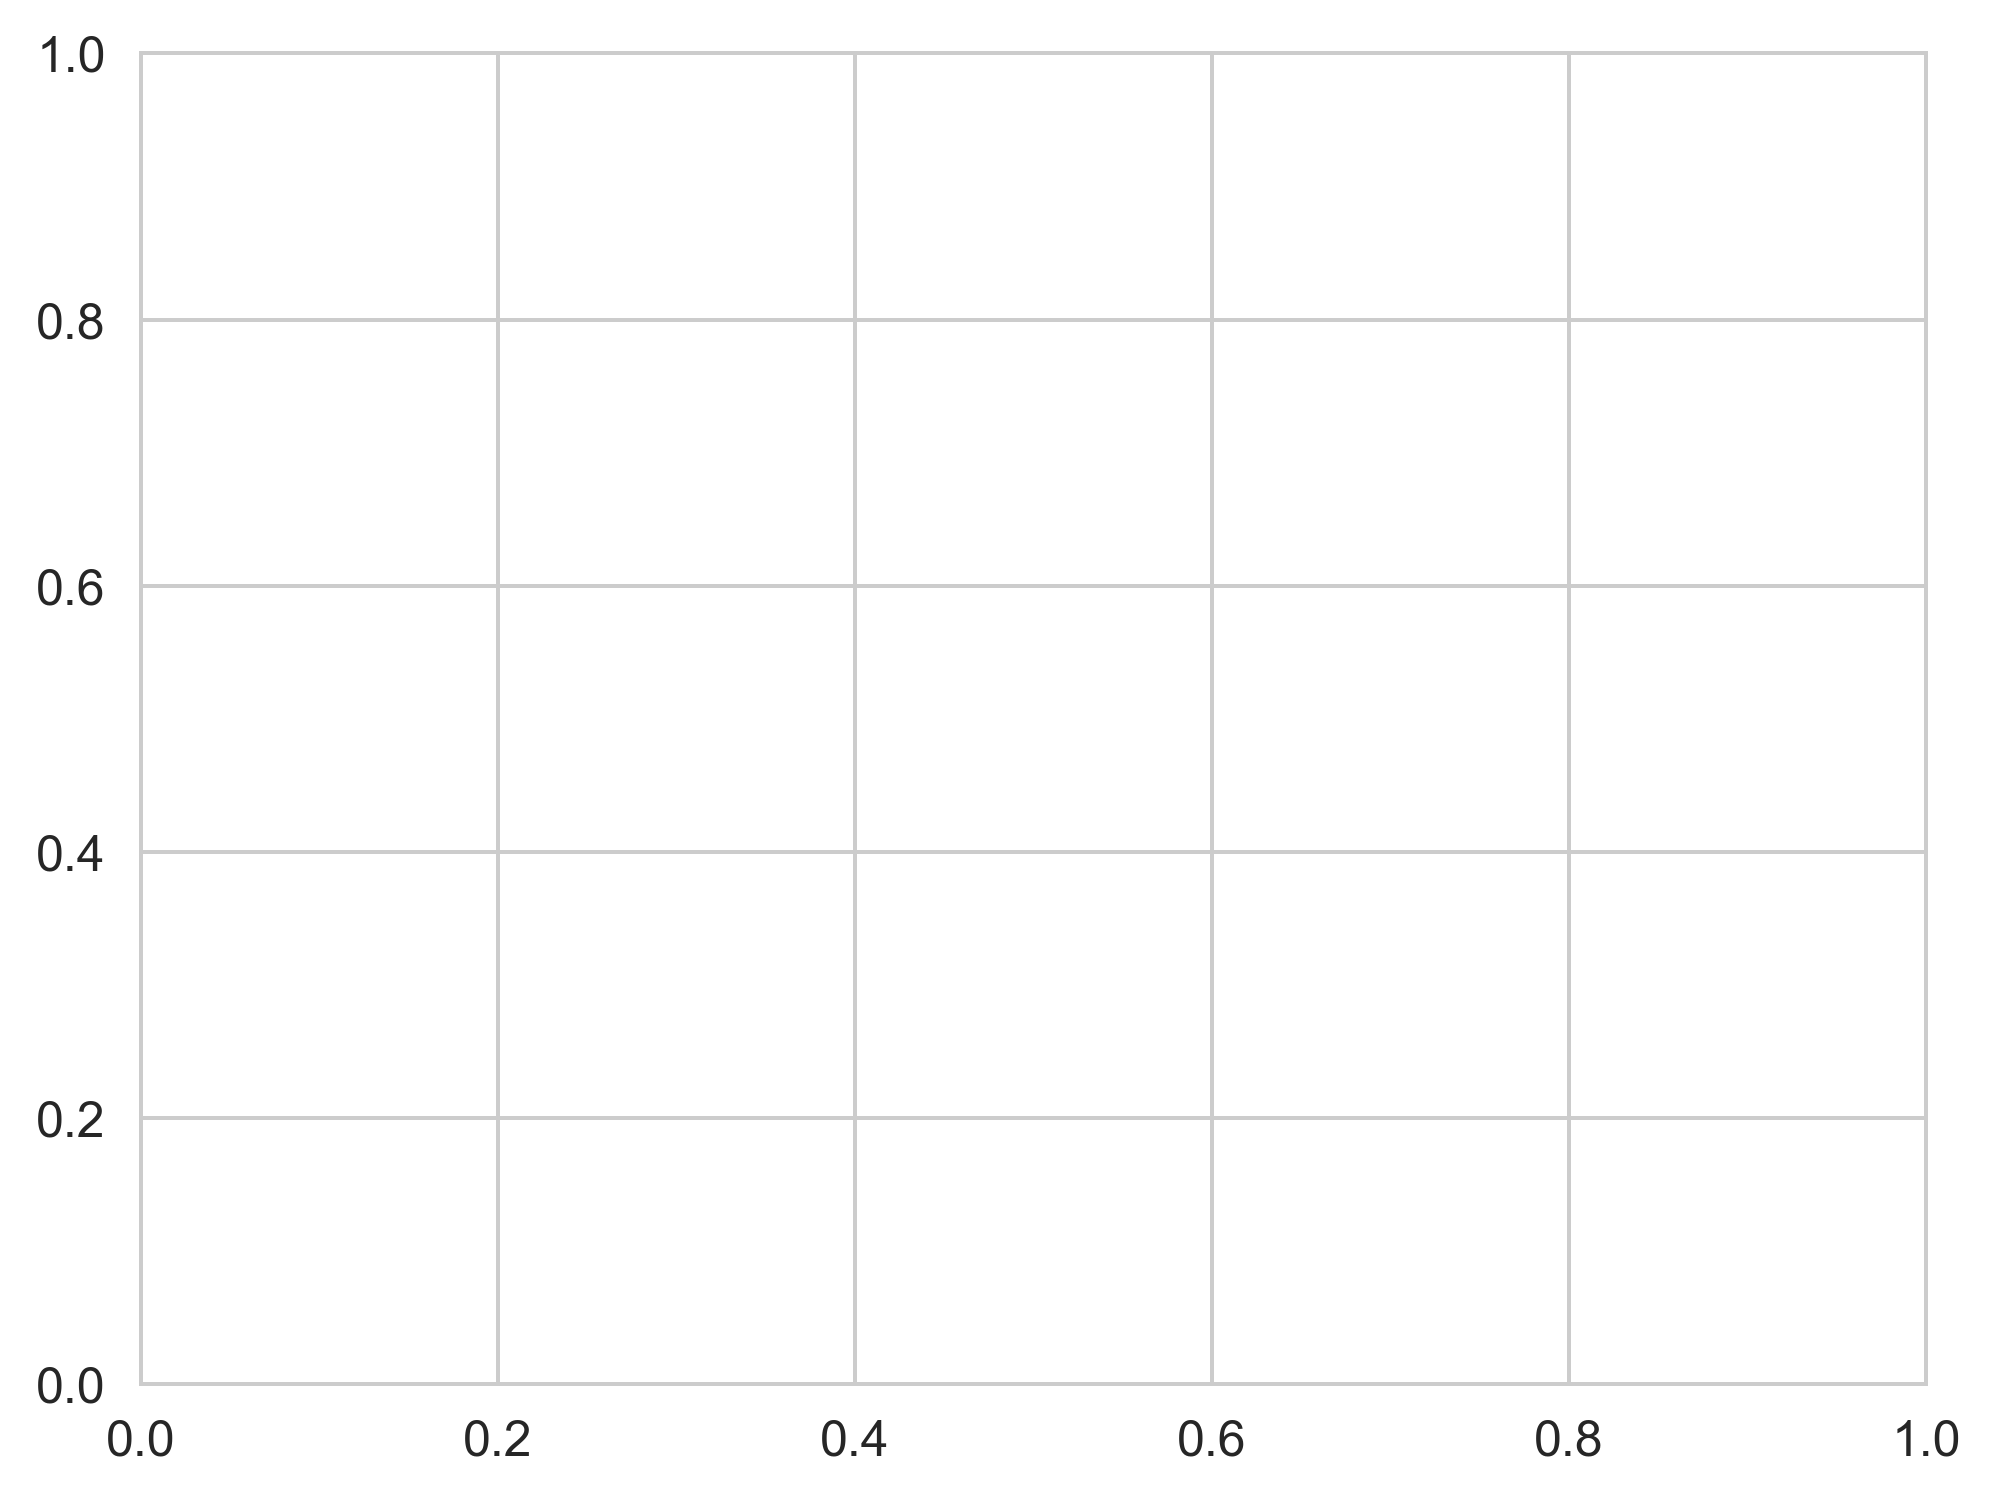

In [55]:
pca_classyfire = PCA(n_components=3, random_state=42)
X = classyfire_family_df.drop(columns=['family', 'ftype'])
components = pca.fit_transform(X)

total_var = pca.explained_variance_ratio_.sum() * 100

fig = px.scatter_3d(
    components, x=0, y=1, z=2, color=df['species'],
    title=f'Total Explained Variance: {total_var:.2f}%',
    labels={'0': 'PC 1', '1': 'PC 2', '2': 'PC 3'}
)
fig.show()

In [48]:
pca_npclassifire = PCA(n_components=2)
Y = np_classifier_family_df.drop(columns=['family', 'ftype'])
npclassifier_components = pca_npclassifire.fit_transform(Y)

principal_npclassifier_df = pd.DataFrame(
    data = npclassifier_components, 
    columns = ['PC1', 'PC2']
)
principal_npclassifier_df['Type'] = np_classifier_family_df['ftype']

In [49]:
pca_npclassifire.explained_variance_ratio_

array([0.2766966, 0.0904666])

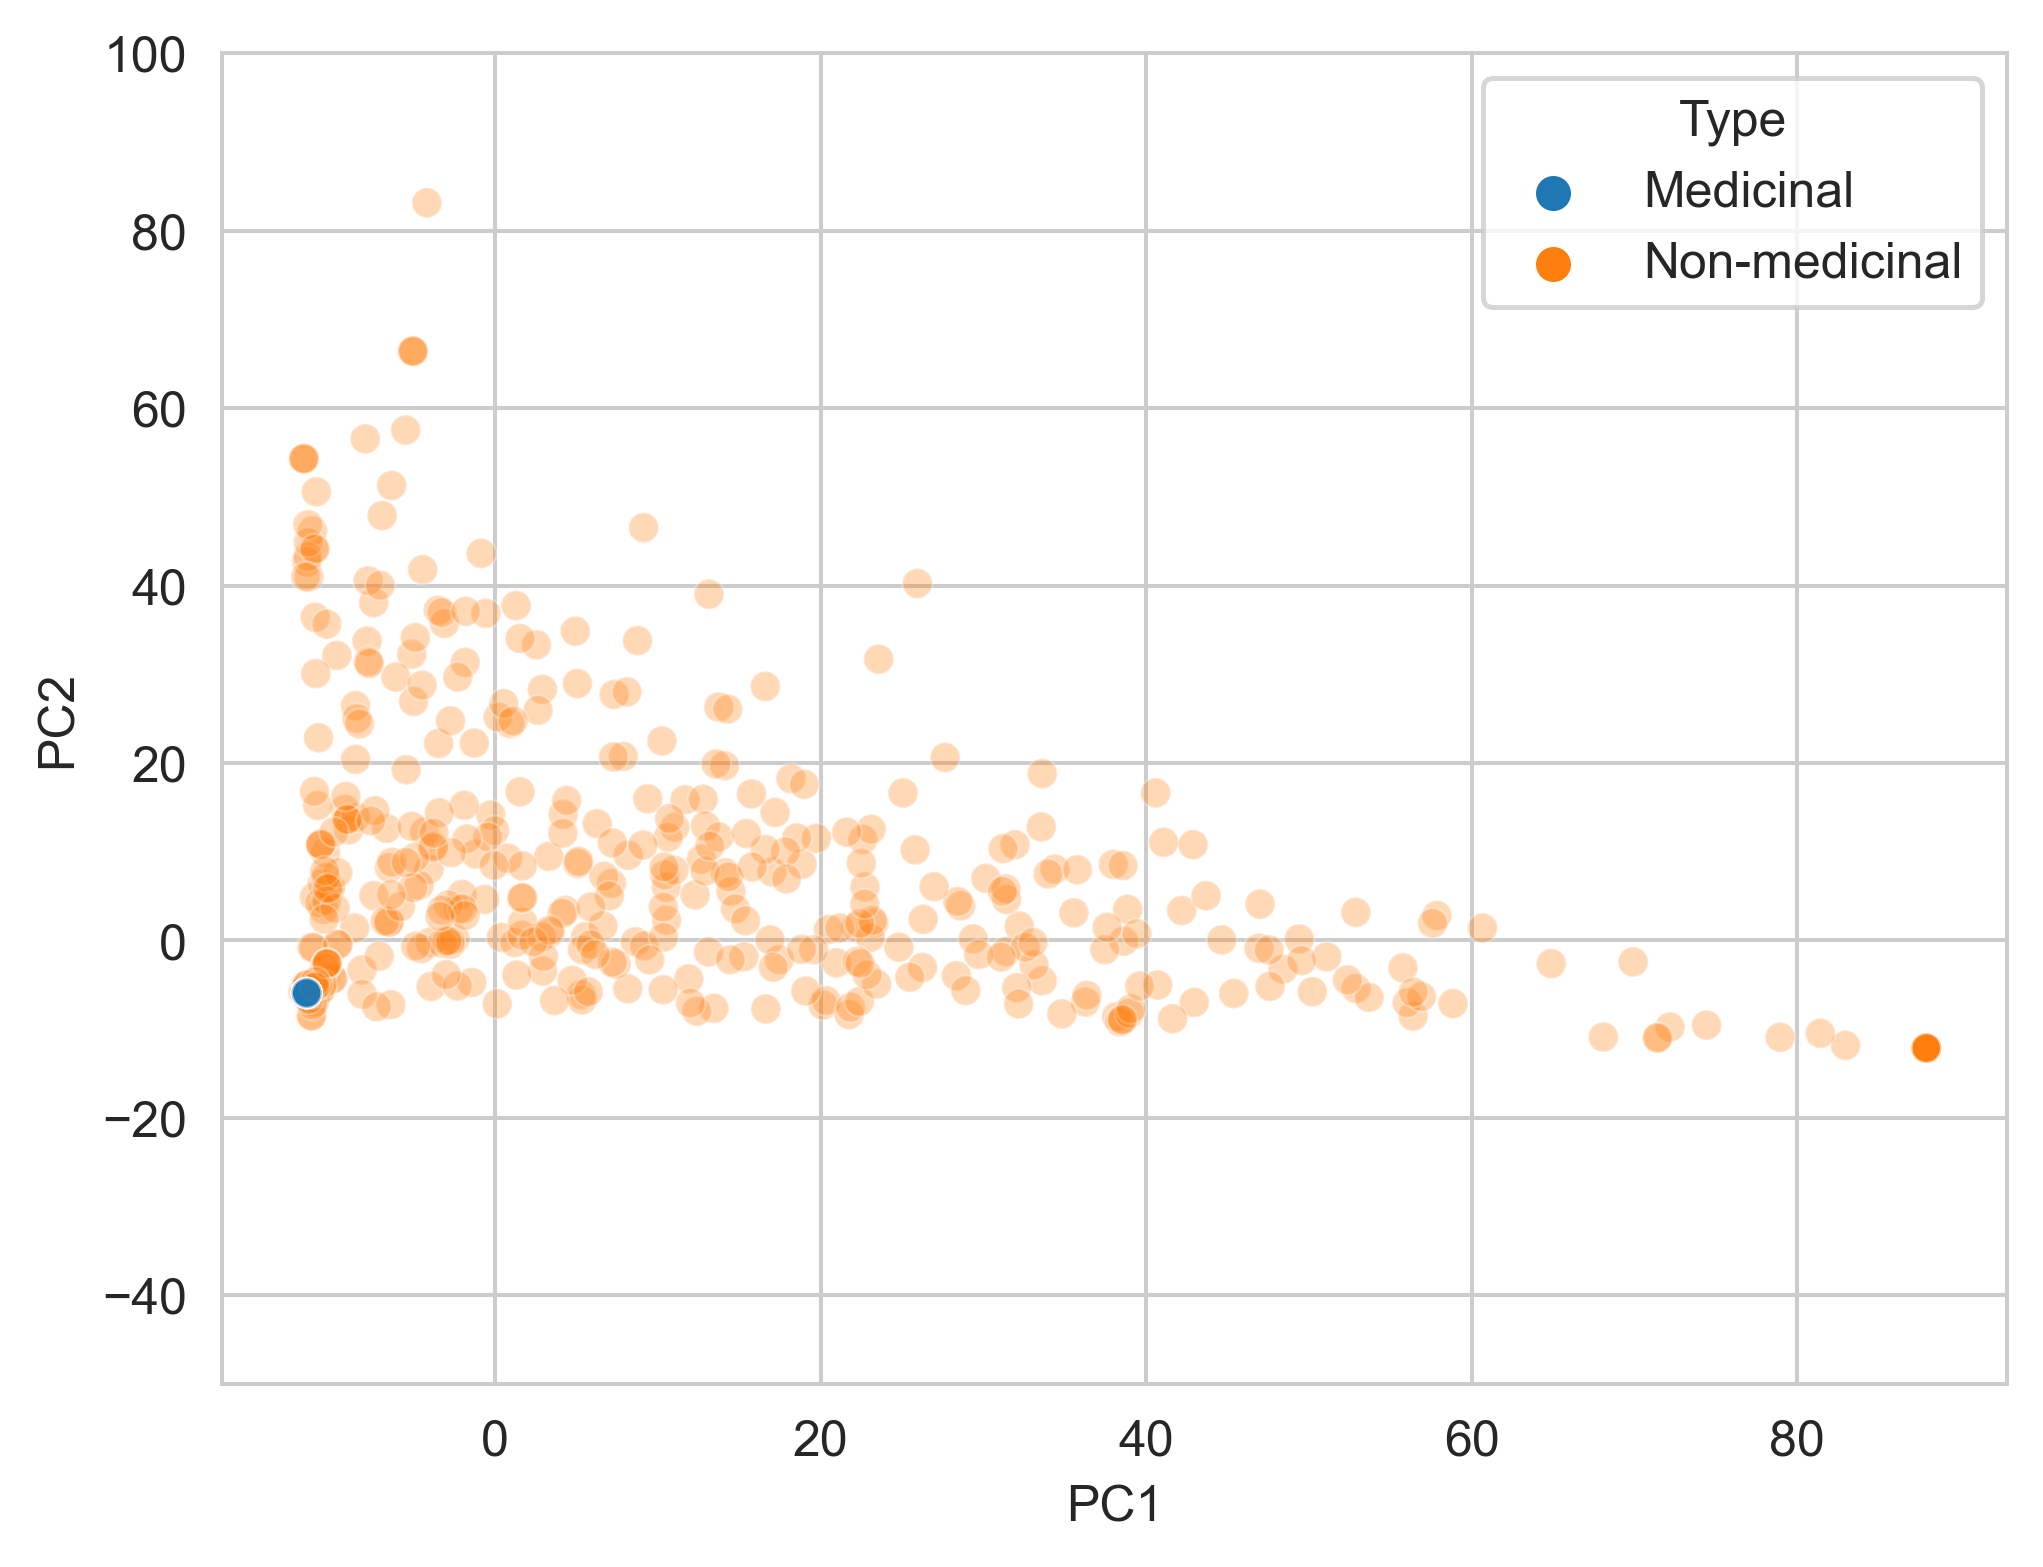

In [50]:
sns.scatterplot(
    data=principal_npclassifier_df,
    x='PC1',
    y='PC2',
    hue='Type',
    alpha=0.3
)
plt.ylim(-50, 100)
plt.show()

In [51]:
import plotly.express as px

In [59]:
principal_classyfire_df[principal_classyfire_df['Type'] == 'Medicinal']

,PC1,PC2,PC3
count,5.040000e+02,5.040000e+02,5.040000e+02
mean,-8.122235e+00,-3.863878e+00,-1.719971e+00
std,4.146682e-15,8.190037e-15,2.439439e-15
min,-8.122235e+00,-3.863878e+00,-1.719971e+00
25%,-8.122235e+00,-3.863878e+00,-1.719971e+00
50%,-8.122235e+00,-3.863878e+00,-1.719971e+00
75%,-8.122235e+00,-3.863878e+00,-1.719971e+00
max,-8.122235e+00,-3.863878e+00,-1.719971e+00
